### Imports

Required packages including those needed for `image_arrays.py`, `hdf_utils.py`, `plot_utils.py`, and `fitting.py`.
- h5py
- numpy
- matplotlib
- scipy
- scikit-image
- symfit

In [37]:
import os
import re
import shutil
import sys
from datetime import date
from copy import deepcopy
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from scipy import signal
from scipy.interpolate import interp2d

# local imports
from image_arrays import *
from hdf_utils import pack_hdf, unpack_hdf
from fitting import BiexpFitter
from plot_utils import clean_axes

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [38]:
# %matplotlib qt 
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})  # suppress too many figures warning

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [69]:
base_path = "/mnt/Data/prerna_noise/"
data_path = os.path.join(base_path, "2022_07_28_processed_4x4/1D_horizontal/5f/")
# data_path = os.path.join(base_path, "2022_05_31_processed_4x4/spot/20f")
depth = "DD"
depth_path = os.path.join(data_path, depth + "/")

# exp = None  # if there is no further breakdown of data in the depth folder
exp = "control"
# exp = "nbqx"
exp_path = depth_path if exp is None else os.path.join(depth_path, exp)

noise_path = os.path.join(data_path, "noise")

with open(os.path.join(exp_path, "conf.json")) as c:
    conf = json.load(c)
    
print("Configuration")
print("-------------")
for k, v in conf.items():
   print("%s:" % k, v) 

Configuration
-------------
stim_width: 300
stim_height: 200
noise_freq: 5
noise_hz: 60
noise_start: 5.0
rec_hz: 58.25
rec_width: 174.65
rec_height: 100.65
x_cropped_pix: 16
y_cropped_pix: 0
x_reduce_pix: 4
y_reduce_pix: 4
rec_x_offset: 0.0
rec_y_offset: 0.0


### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [70]:
auto_transpose = True
h5_noise = True

if h5_noise:
    def noise_loader(pth):
        with h5.File(pth) as f:
            data = f["stimulus"][()]
        return data
    raw_noise = np.stack(
        [
            noise_loader(os.path.join(noise_path, f))
            for f in os.listdir(noise_path) 
            if f.endswith(".h5")
        ],
        axis=0
    )
    # if time axis will always be the longest, if it's last, bring it up
    if auto_transpose and np.argmax(raw_noise.shape) == 3:
        raw_noise = raw_noise.transpose(0, 3, 1, 2)
else:
    raw_noise = np.stack(
        [
            io.imread(os.path.join(noise_path, f))
            for f in os.listdir(noise_path) 
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ], 
        axis=0
    )

raw_noise = (raw_noise if raw_noise.shape[0] > 1 else raw_noise[0]) / 255
# raw_noise = raw_noise.transpose(0, 2, 1)
# raw_noise = np.rot90(raw_noise, k=2, axes=(1, 2))
raw_noise = np.flip(raw_noise, axis=1)
raw_noise = np.flip(raw_noise, axis=2)

# physical dimensions (microns)
stim_width = conf["stim_width"]
stim_height = conf["stim_height"]
stim_extent = (0., stim_width, stim_height, 0.)

noise_freq = conf["noise_freq"]
noise_hz = conf["noise_hz"]
cycle_frames = int(noise_hz / noise_freq)
noise_start = conf["noise_start"]
noise_frames, noise_cols, noise_rows = raw_noise.shape
noise_xaxis = np.arange(noise_frames) * (1 / noise_hz) + noise_start
noise_end = np.max(noise_xaxis)
noise_frame_times = np.array([
    noise_start + (1 / noise_freq) * i 
    for i in range(raw_noise.shape[0] // cycle_frames + 1)
])

print("raw noise shape:", raw_noise.shape)

raw noise shape: (3597, 13, 1)


In [71]:
seed = 121
rng = np.random.default_rng(seed)

frames = []
for _ in range(noise_frames // cycle_frames):
#     frame = rng.integers(low=0, high=2, size=raw_noise.shape[1:]).astype(np.float64)
    frame = np.clip(rng.normal(0.5, size=raw_noise.shape[1:]).astype(np.float64), 0, 1)
    for _ in range(cycle_frames):
        frames.append(frame)
        
fake_noise = np.stack(frames, axis=0)
del frames
print("fake noise shape:", fake_noise.shape)

fake noise shape: (3588, 13, 1)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


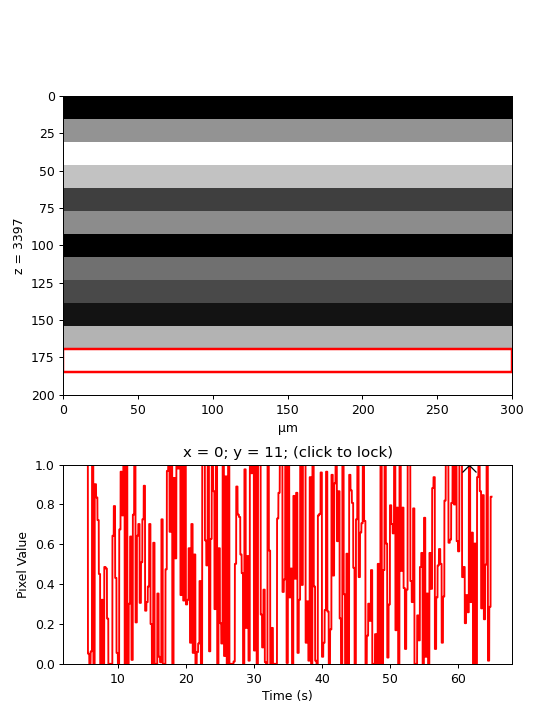

In [72]:
raw_noise_plot = StackExplorer(
    raw_noise,
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)
raw_noise_plot.ax[0].set_xlabel("µm")
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.tight_layout()
raw_noise_plot.fig.show()

### Select (and display) recording to analyse here.
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`). While moving around the ROI, one may left-click to lock it in the current position, allowing interaction with the z-projection axis underneath.

In [43]:
hz = conf["rec_hz"]
dt = 1 / hz

def unpack(pth):
    with h5.File(pth) as f:
        data = unpack_hdf(f)["stack"]
    return data

stacks = np.stack(
    [
        unpack(os.path.join(exp_path, f))
        for f in os.listdir(exp_path) 
        if f.endswith(".h5")
    ],
    axis=0
)

n_trials, n_pts, stack_rows, stack_cols = stacks.shape
mean_stack_proj = np.mean(stacks, axis=(0, 1))

recs_xaxis = np.arange(n_pts) * dt
stim_start_idx = nearest_index(recs_xaxis, noise_xaxis.min())
stim_end_idx = nearest_index(recs_xaxis, noise_xaxis.max())
rec_pts_per_cycle = int(hz / noise_freq)

##### physical dimensions (in microns)
# width and height kept from full scan field (cropped in preprocessing)
x_crop_ratio = (stack_cols - (conf["x_cropped_pix"] / conf["x_reduce_pix"])) / stack_cols
y_crop_ratio = (stack_rows - (conf["y_cropped_pix"] / conf["y_reduce_pix"])) / stack_rows

rec_width = conf["rec_width"] *  x_crop_ratio
rec_height = conf["rec_height"] * y_crop_ratio
rec_x_offset = conf["rec_x_offset"]
rec_y_offset = conf["rec_y_offset"]
rec_extent = (0, rec_width, rec_height, 0)  # for scaling imshow plots

print("stacks shape:", stacks.shape)

stacks shape: (1, 4000, 64, 56)


### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. The currently selected trial will be highlighted in **red**. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

- `delta` sets the number of timesteps/frames that are scrolled per tick
- `roi_size` sets dynamic ROI size in pixels. This can either be scalar (e.g. `1`), or a tuple (e.g. `(1, 2)`) if you want a non-square ROI 

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


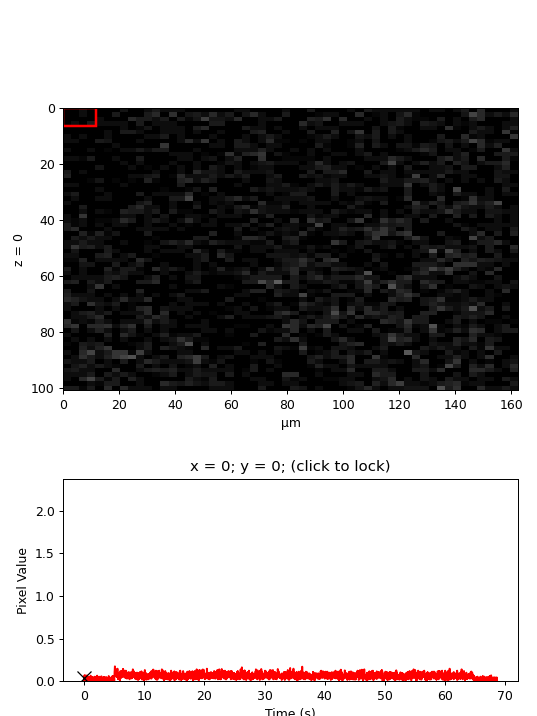

Recording shape: (4000, 64, 56)


In [44]:
stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=4,
    dims=(rec_width, rec_height),
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[0].set_xlabel("µm")
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)

### Grid ROI placement using Quality Index acceptance threshold
Take `grid_w` by `grid_h` beams from the scan field and discard those that do not meet the `min_qi` threshold.

In [45]:
# grid_w = 2
# grid_h = 2
grid_w = 4
grid_h = 4
# grid_w = 8
# grid_h = 8
# grid_w = 8
# grid_h = 16
# grid_w = 56
# grid_h = 64
# grid_w = 2
# grid_h = 32
grid_cols = stack_cols // grid_w
grid_rows = stack_rows // grid_h
col_x = rec_width / stack_cols
row_y = rec_height / stack_rows
grid_x = rec_width / grid_cols
grid_y = rec_height / grid_rows

# min_qi = .5
min_qi = 0.

i = 0
grid_recs, grid_locs, all_qis, accepted_qis, grid_idxs = [[] for _ in range(5)]
for x0 in range(0, stack_cols, grid_w):
    for y0 in range(0, stack_rows, grid_h):
        beams = np.mean(stacks[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
        qi = quality_index(beams[:, stim_start_idx:stim_end_idx])
        all_qis.append(qi)
        if qi > min_qi:
            grid_recs.append(beams)
            grid_locs.append([x0, y0])
            accepted_qis.append(qi)
            grid_idxs.append(i)
        i += 1

raw_grid_recs = np.stack(grid_recs, axis=1)
raw_avg_grid_recs = np.mean(raw_grid_recs, axis=0)
del grid_recs
grid_locs = np.stack(grid_locs, axis=0)
print("number of grid ROIs accepted:", raw_grid_recs.shape[1])

number of grid ROIs accepted: 224


### Quality Index distribution and accepted ROI map
Histogram includes the entire distribution of QIs, while the plot below highlights the locations of the passable QI ROIs in space. Red squares with red QI indicate ROIs that have been accepted, white values correspond to ROIs that did not reach the quality index threshold `min_qi`.

<IPython.core.display.Javascript object>


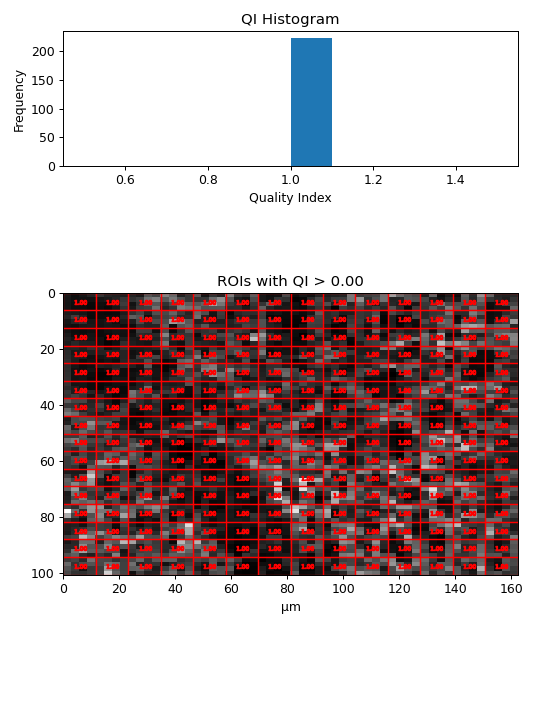

In [46]:
half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(
    2, 
    gridspec_kw={"height_ratios": [.2, .8]}, 
    figsize=(6, 8)
)

grid_ax[0].hist(all_qis)
grid_ax[0].set_title("QI Histogram")
grid_ax[0].set_xlabel("Quality Index")
grid_ax[0].set_ylabel("Frequency")

grid_ax[1].imshow(mean_stack_proj, extent=rec_extent, cmap="gray")
grid_ax[1].set_title("ROIs with QI > %.2f" % min_qi)
grid_ax[1].set_xlabel("µm")

for (x, y) in grid_locs:
    grid_ax[1].add_patch(
        Rectangle(
            (x * col_x, y * row_y),  # grid offset
            grid_x, 
            grid_y, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

i = 0
for x0 in range(0, stack_cols, grid_w):
    for y0 in range(0, stack_rows, grid_h):
        grid_ax[1].scatter(
            (x0 + half_w) * col_x,
            (y0 + half_h) * row_y, 
            marker="$%s$" % ("%.2f" % all_qis[i]).lstrip("0"), 
            s=100,
            c="red" if all_qis[i] > min_qi else "1",
        )
        i += 1
        
grid_fig.tight_layout()

### Denoise and signal-noise normalize ROI responses

In [47]:
grid_recs = (
    raw_grid_recs 
    / np.var(raw_grid_recs[:, :, -200:], axis=2).reshape(*raw_grid_recs.shape[:2], 1)
)
grid_recs -= np.mean(grid_recs[:, :, -200:], axis=2).reshape(*grid_recs.shape[:2], 1)

# again for the trial average
avg_grid_recs = (
    raw_avg_grid_recs 
    / np.var(raw_avg_grid_recs[:, -200:], axis=1).reshape(raw_avg_grid_recs.shape[0], 1)
)
avg_grid_recs -= np.mean(avg_grid_recs[:, -200:], axis=1).reshape(avg_grid_recs.shape[0], 1)

In [48]:
tau1 = 2 # rise [ms]
# tau2 = 30  # decay [ms]
tau2 = 40  # decay [ms]
quantum_pts = 100

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

template = biexp_quantum / biexp_quantum.max()
template = np.concatenate([np.zeros(quantum_pts), template])
template = np.flip(template)

grid_detrend = map_axis(lambda a: a - rolling_average(a, n=120), grid_recs)
avg_grid_detrend = map_axis(lambda a: a - rolling_average(a, n=120), avg_grid_recs)
grid_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), grid_recs)
avg_grid_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), avg_grid_recs)
detrend_conv = map_axis(lambda a: a - rolling_average(a, n=120), grid_conv)
avg_detrend_conv = map_axis(lambda a: a - rolling_average(a, n=120), avg_grid_conv)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates
- **wlen:** size of sliding window used for computing prominence

<IPython.core.display.Javascript object>


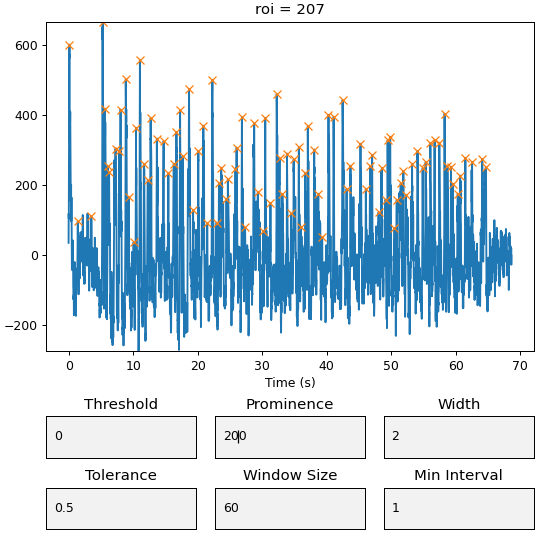

In [49]:
# display_recs = grid_recs[0], 
# display_recs = grid_detrend[0],
# display_recs = avg_grid_recs,
# display_recs = grid_conv[0],
display_recs = detrend_conv[0]
# display_recs = avg_detrend_conv

peak_explorer = PeakExplorer(
    recs_xaxis, 
    display_recs,
    prominence=150,
    width=2,
    tolerance=.5,
    distance=1,
#     distance=rec_pts_per_cycle // 2,
    wlen=60,
)

show_frame_times = False
if show_frame_times:
    for t in noise_frame_times:
        peak_explorer.rec_ax.plot(
            [t, t], [display_recs.min(), display_recs.max()],
            c="black", alpha=0.5, linestyle="--", linewidth=0.5
        )

### Create response triggered average of stimulus movie, and use a rough transformation of the cell ROI to calculate the average intensity over time.
- `roi_idx` sets the ROI used to generate the triggered stimulus. Make use of the mask and beam scrollers above to pick out ROIs that you might want to do this with
- `lead` sets the time (in seconds) to use preceding each threshold passing event.
- peak finding parameters correspond to those above, set them here in order to influence the stimulus triggered window calculation.
- `max_prominence` sets a clip off point for peaks, such that errantly large events do not completely wash out the rest (due to prominence scaling using softmax). This is optional, and can be set to `None` or commented out from the arguments given to `avg_trigger_window`.

The dotted blue outline represents the relative postion and size of the recording scan field. This can be removed by simply changing the value in the conditional to `0` (or `False`). 

In [73]:
lead_time = 2.             # length of triggered average movie (seconds before peak)
post_time = 1.
peak_threshold = 0     # difference between peaks and their adjacent points
prominence = 200       # difference between peaks and their surrounding troughs
avg_prominence = prominence * 2.
peak_width = 2         # minimum number of points (within tolerance)
peak_tolerance = .6    # ratio value can drop from peak within width
window_size = 60       # length of the window used to calculate prominence
min_peak_interval = 1  # number of points required between peaks
max_prominence = None     # clip to avoid dominance by errant peaks
start_time = 10        # time to begin using peaks for triggered average
end_time = None        # cutoff time for considering peaks
min_peak_count = 20    # ROIs with fewer peaks are thrown out

lead_xaxis = trigger_xaxis(noise_xaxis, lead_time, post_time)
lead_frames = len(lead_xaxis)

# NOTE: ROIs to do not meet `min_peak_count` will be thrown out, so pos_to_roi 
# must be used from here on for lining up ROI numbers with the index in
# lead_stacks and derived arrays
lead_stacks, legal_times, all_peak_idxs = [], [], []
count, pos_to_roi, roi_to_pos = 0, [], {}

# add avg_recs to end, then split out the results to decrease duplication
# combined_recs = np.concatenate([grid_recs, np.expand_dims(avg_grid_recs, 0)], axis=0)
# combined_recs = np.concatenate([grid_conv, np.expand_dims(avg_grid_conv, 0)], axis=0)
combined_recs = np.concatenate([detrend_conv, np.expand_dims(avg_detrend_conv, 0)], axis=0)
    
for i in range(combined_recs.shape[1]): 
    all_peaks, windows, legals = [], [], []
    for j in range(combined_recs.shape[0]):
        peak_idxs, peak_proms = find_peaks(
            combined_recs[j, i],
            threshold=peak_threshold,
            prominence=prominence if j < combined_recs.shape[0] - 1 else avg_prominence,
            width=peak_width,
            wlen=window_size,
            rel_height=peak_tolerance,
            distance=min_peak_interval
        )
        trig, times = avg_trigger_window(
            noise_xaxis, 
            raw_noise,
#             fake_noise,
            recs_xaxis,
            lead_time,
            post_time,
            peak_idxs[0],
            prominences=peak_proms[0],
            max_prominence=max_prominence,
            nonlinear_weighting=True,
            start_time=start_time,
            end_time=end_time,
        )
        windows.append(trig)
        legals.append(times)
        all_peaks.append(peak_idxs)
        
    # rois with trials without triggers are dropped (lookups track the gaps)
    if all(map(lambda l: len(l) > min_peak_count, legals[:-1])):
        lead_stacks.append(np.stack(windows, axis=0))
        legal_times.append(legals)
        all_peak_idxs.append(all_peaks)
        pos_to_roi.append(i)
        roi_to_pos[i] = count
        count += 1
        
del combined_recs
        
# split trial and average output
avg_lead_stacks = np.stack([l[-1] for l in lead_stacks], axis=0)
lead_stacks = np.stack([l[:-1] for l in lead_stacks], axis=0)
avg_legal_times = [l[-1] for l in legal_times]
legal_times = [l[:-1] for l in legal_times]
n_legals = np.stack(
    [np.array([len(l) for l in ts]) for ts in legal_times],
    axis=0
)
n_avg_legals = np.array([len(ts) for ts in avg_legal_times])

all_peak_times = [
    [
        recs_xaxis[tr[0]][(noise_start < recs_xaxis[tr[0]]) * (recs_xaxis[tr[0]] < noise_end)] 
        for tr in roi
    ] 
    for roi in all_peak_idxs
]
avg_all_peak_times = [l[-1] for l in all_peak_times]
all_peak_times = [l[:-1] for l in all_peak_times]

# shape of lead_stacks is [n_kept_rois, n_trials, lead_frames, n_cols, n_rows]
mean_lead_stacks = np.mean(lead_stacks, axis=1)
all_roi_lead_stack = np.mean(lead_stacks, axis=0)
n_kept_rois = len(pos_to_roi)
thrown = grid_recs.shape[1] - n_kept_rois
print("number of ROIs thrown out:", thrown)
print("ROIs remaining:", n_kept_rois)
print("lead_stacks shape:", lead_stacks.shape)

number of ROIs thrown out: 0
ROIs remaining: 224
lead_stacks shape: (224, 1, 180, 13, 1)


### Show locations and indices of remaining grid ROIs
The indices displayed below correspond to the `grid_recs` array, which holds all of the grid ROI beams that passed the initial quality check. Not all of them are represented here, as some ROIs are thrown out at the peak detection stage before calculating triggered stimuli. As down elsewhere, the `pos_to_roi` lookup list is used to translated the position/index in the set of "kept" ROIs to the ROIs found in the `grid_recs` array (which have undergone selection previously, thus the gaps in numbering)

<IPython.core.display.Javascript object>


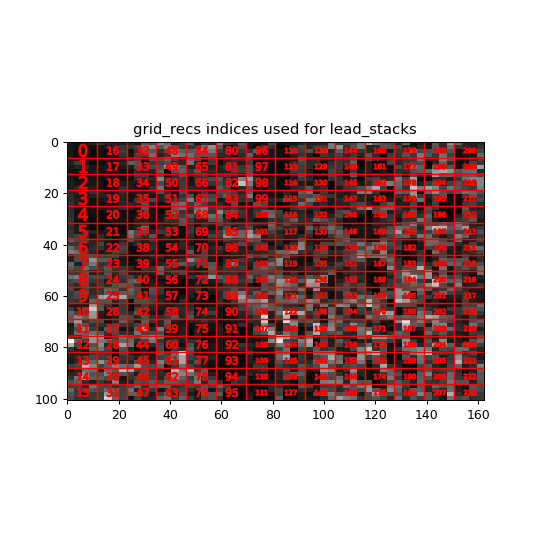

In [74]:
grid_idx_fig, grid_idx_ax = plt.subplots(1, figsize=(6, 6))
grid_idx_ax.imshow(mean_stack_proj, extent=rec_extent, cmap="gray")
grid_idx_ax.set_title("grid_recs indices used for lead_stacks")

for i, (x, y) in enumerate(grid_locs[pos_to_roi]):
    grid_idx_ax.add_patch(
        Rectangle(
            (x * col_x, y * row_y),  # grid offset
            grid_x, 
            grid_y, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )
    grid_idx_ax.scatter(
        (x + half_w) * col_x,
        (y + half_h) * row_y, 
        marker="$%i$" % pos_to_roi[i], 
#         marker="$%i$" % grid_idxs[i], 
        s=100,
        c="red",
    )

In [75]:
noise_freq = 2.
kernel_frames = int(60. / noise_freq)
# reversed to work as intended with convolve
kernel_ones = np.ones(kernel_frames)
kernel_zeros = np.zeros(kernel_frames)
decrement = np.concatenate([kernel_ones * -1., kernel_ones])
increment = np.concatenate([kernel_ones, kernel_ones * -1.])
decr_sin = np.sin(np.linspace(-np.pi, np.pi, kernel_frames * 2))
incr_sin = np.flip(decr_sin)
decr_sin_cycle = np.concatenate([kernel_zeros, decr_sin, kernel_zeros])
incr_sin_cycle = np.flip(decr_sin_cycle)
decrement_cycle = np.concatenate([kernel_zeros, decrement, kernel_zeros])
increment_cycle = np.concatenate([kernel_zeros, increment, kernel_zeros])

# contrast_filter_fig, contrast_filter_ax = plt.subplots(2)
# contrast_filter_ax[0].plot(np.arange(len(increment_cycle)) * (1. / 60.), increment_cycle)
# contrast_filter_ax[0].plot(np.arange(len(incr_sin)) * (1. / 60.) + 0.5, incr_sin)
# contrast_filter_ax[1].plot(np.arange(len(decrement_cycle)) * (1. / 60.), decrement_cycle)
# contrast_filter_ax[1].plot(np.arange(len(decr_sin)) * (1. / 60.) + 0.5, decr_sin)

In [76]:
def trigger_stim_conv(kernel):
    def f(mov):
        shape = mov.shape
        mov = mov.transpose(1, 2, 0)
        mov = map_axis(lambda a: np.convolve(a, kernel, mode="same"), mov)
        return mov.transpose(2, 0, 1)
    return f

lead_stacks_conv = map_axis(
#     trigger_stim_conv(increment_cycle / len(increment_cycle)),
#     trigger_stim_conv(decrement_cycle / len(decrement_cycle)),
    trigger_stim_conv(incr_sin / len(incr_sin)),
    lead_stacks - 0.5,
    axis=2
)
mean_lead_stacks_conv = map_axis(
    trigger_stim_conv(incr_sin / len(incr_sin)),
    mean_lead_stacks - 0.5,
    axis=1
)
avg_lead_stacks_conv = map_axis(
    trigger_stim_conv(incr_sin / len(incr_sin)),
    avg_lead_stacks - 0.5,
    axis=1
)

<IPython.core.display.Javascript object>


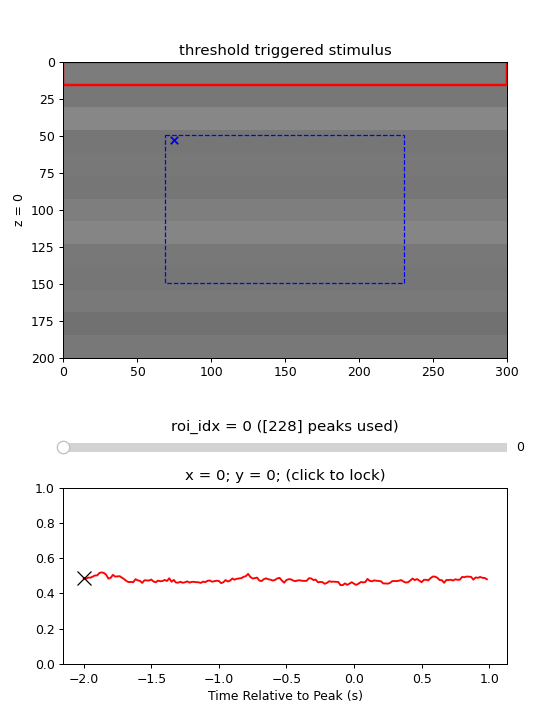

In [77]:
def roi_fmt_fun(i):
    return "roi_idx = %i (%s peaks used)" % (pos_to_roi[i], str(n_legals[i]))

lead_stack_plot = StackExplorer(
    lead_stacks,
#     lead_stacks_conv,
    zaxis=lead_xaxis,
    delta=2,
    roi_sz=1,
    vmin=0.,
    vmax=1.,
    n_fmt_fun=roi_fmt_fun,
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

x_corner = (stim_width - rec_width) / 2 + rec_x_offset
y_corner = (stim_height - rec_height) / 2 + rec_y_offset

def scan_field_rect():
    return Rectangle(
        (x_corner - .5, y_corner - .5),  # grid offset
        rec_width, 
        rec_height, 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )

def update_roi_mark(mark):
    def f(i):
        idx = pos_to_roi[int(i)]
        x, y = grid_locs[idx]
        x = (x + half_w) * col_x + x_corner 
        y = (y + half_h) * row_y + y_corner 
        mark.set_offsets([[x, y]])
    return f

lead_stack_plot.ax[0].add_patch(scan_field_rect())
lead_roi_mark = lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(lead_roi_mark)(0)    
if lead_stack_plot.n_sz > 1:
    lead_stack_plot.n_slider.on_changed(update_roi_mark(lead_roi_mark))

lead_stack_plot.fig.show()

### Triggered Stimulus calculated from average recording
If there was more than one trial, repeat above, but using the average of the recordings to determing peak/event timings, rather than individual trials (with subsequent averaging of the triggered stimuli). 

In [78]:
if n_trials > 1:
    def avg_roi_fmt_fun(i):
        return "roi_idx = %i (%s peaks used)" % (pos_to_roi[i], str(n_avg_legals[i]))

    avg_lead_stack_plot = StackExplorer(
        np.expand_dims(avg_lead_stacks, 1),
        zaxis=lead_xaxis,
        delta=1,
        roi_sz=1,
        vmin=0,
        vmax=1,
        n_fmt_fun=avg_roi_fmt_fun,
        dims=(stim_width, stim_height),
        figsize=(6, 8)
    )
    avg_lead_stack_plot.stack_ax.set_title("(avg rec) threshold triggered stimulus")
    avg_lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
    avg_lead_stack_plot.fig.tight_layout()
    
    avg_lead_stack_plot.ax[0].add_patch(scan_field_rect())
    avg_lead_roi_mark = avg_lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
    update_roi_mark(avg_lead_roi_mark)(0)    
    if avg_lead_stack_plot.n_sz > 1:
        avg_lead_stack_plot.n_slider.on_changed(update_roi_mark(avg_lead_roi_mark))
    avg_lead_stack_plot.fig.show()

## Space Time plot for 1D noise stimuli
If the noise does not have a one dimensional spatial axis, skip over.

<IPython.core.display.Javascript object>


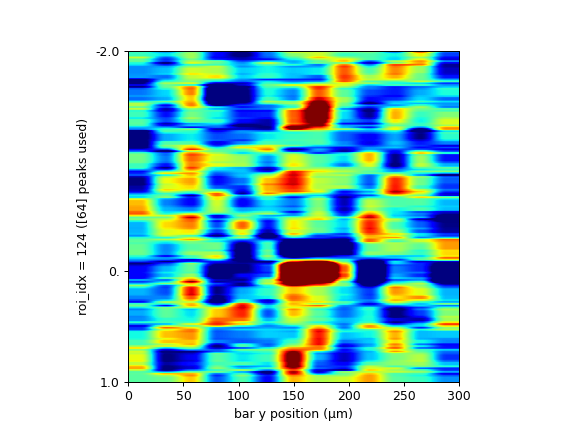

In [79]:
x1d = raw_noise.shape[1] == 1
y1d = raw_noise.shape[2] == 1

if (x1d or y1d) and not (x1d and y1d):
    time_dim = 300
    vertical = raw_noise.shape[1] == 1
    if vertical:
        lead_stacks_1d = np.mean(lead_stacks[:, :, :, 0, :], axis=1)
    else:
        lead_stacks_1d = np.mean(lead_stacks[:, :, :, :, 0], axis=1)

    lead_space_time_fig, lead_space_time_ax = plt.subplots(1)
    lead_space_time_plot = StackPlotter(
        lead_space_time_fig,
        lead_space_time_ax,
        lead_stacks_1d,
        delta=1,
    #     z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
        z_fmt_fun=roi_fmt_fun,
        cmap="jet",
        dims=(stim_width, time_dim),
    )

    bar_dim = "x" if vertical else "y"
    zero_tick = time_dim * (lead_time / (lead_time + post_time))
    lead_space_time_ax.set_yticks([0, zero_tick, time_dim])
    lead_space_time_ax.set_yticklabels([-lead_time, "0.", post_time])
    lead_space_time_ax.set_ylabel("Time (s)")
    lead_space_time_ax.set_xlabel("bar %s position (μm)" % bar_dim)

## Response Triggered Responses
Calculate the average response across the scan field as triggered by the events in each individual ROI.

In [80]:
start_idx = int(10 * hz)

def fill_grid(rs):
    total_cells = grid_rows * grid_cols
    if rs.shape[0] < total_cells:
        temp, last_i, blank = [], 0, np.zeros(rs.shape[-1])
        for i, r in zip(grid_idxs, rs):
            for j in range(max(i - last_i - 1, 0)):
                temp.append(blank)
            temp.append(r)
            last_i = i
            
        for j in range(total_cells - len(temp)):
            temp.append(blank)
            
        return np.stack(temp, axis=0)
    else:
        return np.copy(rs)

fill_recs = np.stack([fill_grid(rs) for rs in grid_recs], axis=0)
fill_conv = np.stack([fill_grid(rs) for rs in detrend_conv], axis=0)
n_pts = fill_recs.shape[-1] 

# lead_time = 0.5
# post_time = 0.5
lead_time_ev = 1.
post_time_ev = 1.

windows, event_n_peaks = [], []
for trial_rec, trial_conv in zip(fill_recs, fill_conv): 
    ws, ns = [], []
    for roi in trial_conv: 
        peak_idxs, peak_proms = find_peaks(
            roi,
            prominence=prominence,
            width=peak_width,
            rel_height=peak_tolerance,
            distance=min_peak_interval
        )
            
        trig, times = avg_trigger_window(
            np.arange(n_pts) * dt, 
            trial_rec.reshape(grid_cols, grid_rows, -1).transpose(2, 1, 0),
            np.arange(n_pts) * dt,
            lead_time_ev,
            post_time_ev,
            peak_idxs[0],
            prominences=peak_proms[0],
            nonlinear_weighting=True,
        )
        ws.append(trig)
        ns.append(len(times))
    windows.append(ws)
    event_n_peaks.append(ns)
    
triggered_events = np.array(windows).transpose(1, 0, 2, 3, 4)
triggered_events = triggered_events - triggered_events.mean(axis=2, keepdims=True)
event_n_peaks = np.array(event_n_peaks).T

del windows

<IPython.core.display.Javascript object>


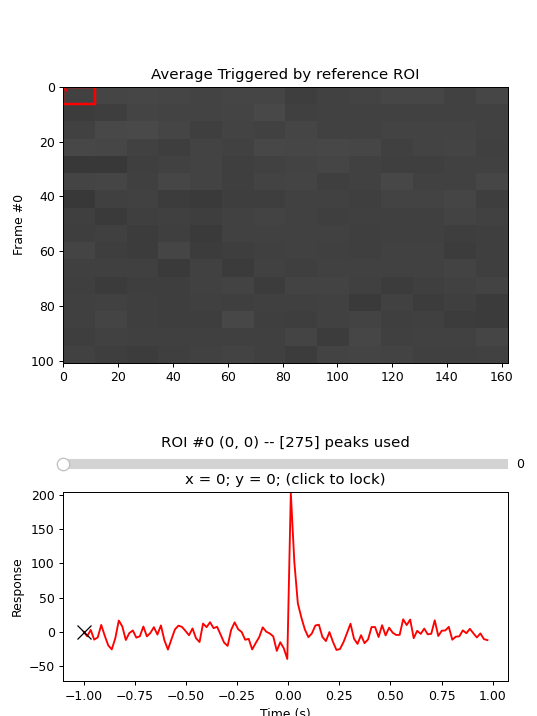

Text(0.5, 1.0, 'Average Triggered by reference ROI')

In [81]:
def event_roi_fmt_fun(i):
    return (
        "ROI #%i (%i, %i) -- %s peaks used" 
        % (i, i // grid_rows, i % grid_rows, str(event_n_peaks[i]))
    )

event_xaxis = np.arange(triggered_events.shape[2]) * (1 / hz) - lead_time_ev

triggered_event_plot = StackExplorer(
    triggered_events,
    zaxis=event_xaxis,
    delta=1,
    roi_sz=1,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
    n_fmt_fun=event_roi_fmt_fun,
    dims=(rec_width, rec_height),
    figsize=(6, 8)
)
triggered_event_plot.beam_ax.set_xlabel("Time (s)")
triggered_event_plot.beam_ax.set_ylabel("Response")
triggered_roi_mark = triggered_event_plot.ax[0].scatter([0], [0], marker="x", c="red")
if triggered_event_plot.n_sz > 1:
    triggered_event_plot.n_slider.on_changed(
        lambda v: triggered_roi_mark.set_offsets(
            [[(v // grid_rows + 0.5) * triggered_event_plot.x_frac, 
              (v % grid_rows + 0.5) * triggered_event_plot.y_frac]]))

triggered_event_plot.ax[0].set_title("Average Triggered by reference ROI")

<IPython.core.display.Javascript object>


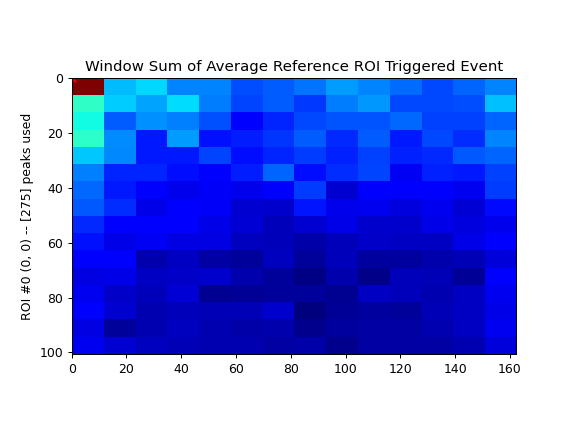

In [82]:
mid_trig_idx = len(event_xaxis) // 2
area_win_pre_dur = 0.
area_win_post_dur = 0.1
area_win_pre_pts = int(area_win_pre_dur * hz)
area_win_post_pts = int(area_win_post_dur * hz)

trig_area_grid_stack = np.sum(
    triggered_events[:, 0, mid_trig_idx-area_win_pre_pts:mid_trig_idx+area_win_post_pts], 
    axis=1
)

trig_area_grid_fig, trig_area_grid_ax = plt.subplots(1)
trig_area_grid_plot = StackPlotter(
    trig_area_grid_fig,
    trig_area_grid_ax,
    trig_area_grid_stack,
    delta=1,
    z_fmt_fun=event_roi_fmt_fun,
    cmap="jet",
    dims=(rec_width, rec_height),
)

trig_area_mark = trig_area_grid_plot.ax.scatter([0], [0], marker="x", c="red")
trig_area_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: trig_area_mark.set_offsets(
        [[(trig_area_grid_plot.idx // grid_rows + 0.5) * trig_area_grid_plot.x_frac,
          (trig_area_grid_plot.idx % grid_rows + 0.5) * trig_area_grid_plot.y_frac]]
    )
)

trig_area_grid_ax.set_title("Window Sum of Average Reference ROI Triggered Event")

trig_area_grid_fig.canvas.capture_scroll = True

<IPython.core.display.Javascript object>


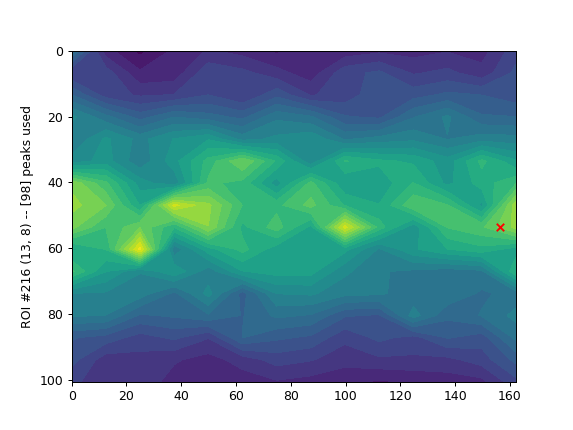

In [84]:
# skip if ROIs are "full-field" in either dimension
if grid_rows > 1 and grid_cols > 1:
    trig_area_contour_fig, trig_area_contour_ax = plt.subplots(1)
    trig_area_contour_plot = ContourStackPlotter(
        trig_area_contour_fig,
        trig_area_contour_ax,
        trig_area_grid_stack,
        levels=20,
        delta=1,
        z_fmt_fun=event_roi_fmt_fun,
        dims=(rec_width, rec_height),
        fill_mode=True,
    )

    trig_area_contour_plot.fig.canvas.mpl_connect(
        "scroll_event",
        lambda e: trig_area_contour_plot.ax.scatter(
            [(trig_area_contour_plot.idx // grid_rows + 0.5) * trig_area_contour_plot.x_frac],
            [(trig_area_contour_plot.idx % grid_rows + 0.5) * trig_area_contour_plot.y_frac],
            marker="x",
            c="red"
        )
    )

### Evolution of peak timing relative to noise frame updates over time

In [25]:
all_peak_lags = []
for r in all_peak_times:
    roi = []
    for tr in r:
        trial = []
        for t in tr:
            # index before which to insert to preserve sorting
            idx = np.searchsorted(noise_frame_times, t, side="left")
            # thus, previous index will be the frame time that preceded the event `t`
            diff = (t - noise_frame_times[idx - 1])
            trial.append(diff)
        roi.append(np.array(trial))
    all_peak_lags.append(roi)
    
trial_peak_times = {
    t: {r: all_peak_times[r][t] for r in range(len(all_peak_times))} 
    for t in range(n_trials)
}
trial_peak_lags = {
    t: {r: all_peak_lags[r][t] for r in range(len(all_peak_lags))}
    for t in range(n_trials)
}

<IPython.core.display.Javascript object>


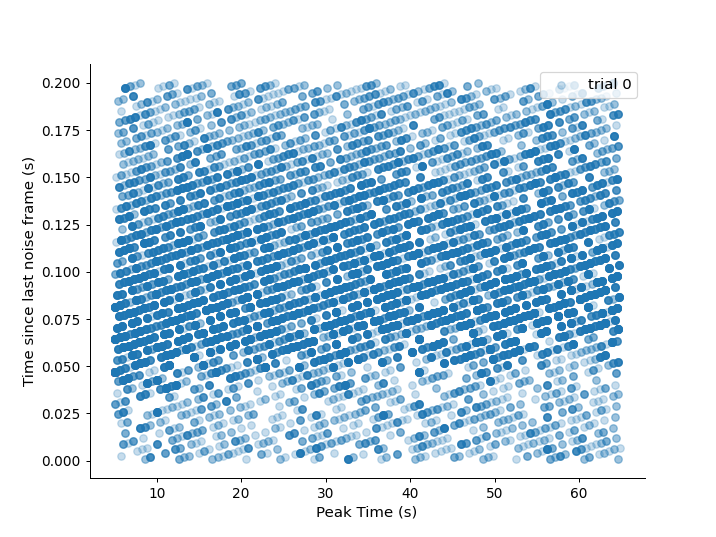

In [26]:
trial_lag_over_fig, trial_lag_over_ax = plt.subplots(1, figsize=(8, 6))
for i, (times, lags) in enumerate(zip(trial_peak_times.values(), trial_peak_lags.values())):
    trial_lag_over_ax.scatter(
        [t for roi in times.values() for t in roi], [t for roi in lags.values() for t in roi], 
        label="trial %i" % i,
        alpha=0.25,
    )
    
trial_lag_over_ax.set_ylabel("Time since last noise frame (s)", fontsize=12)
trial_lag_over_ax.set_xlabel("Peak Time (s)", fontsize=12)
trial_lag_over_ax.legend(fontsize=12, loc="upper right")
clean_axes(trial_lag_over_ax)

Break up trials (if there is more than one).

In [27]:
if n_trials > 1:
    trial_lag_fig, trial_lag_ax = plt.subplots(n_trials, sharex=True, sharey=True, figsize=(8, 10))
    for i, (ax, times, lags) in enumerate(
        zip(trial_lag_ax, trial_peak_times.values(), trial_peak_lags.values())):
        ax.scatter(
            [t for roi in times.values() for t in roi], 
            [t for roi in lags.values() for t in roi], 
            alpha=0.5
        )
        ax.set_ylabel("trial %i" % i, fontsize=12)
        
        
    trial_lag_fig.suptitle("Time since last noise frame (s)", fontsize=12)
    trial_lag_ax[-1].set_xlabel("Peak Time (s)", fontsize=12)
    clean_axes(trial_lag_ax)

### Rough "receptive field" map via response vs baseline subtraction
Set baseline and response windows in terms of `lead_xaxis`. Subtractions for all trials, as well as averages will be calculated and displayed in an interactive plot. Use mouse scroll to cycle between ROIs.

<IPython.core.display.Javascript object>


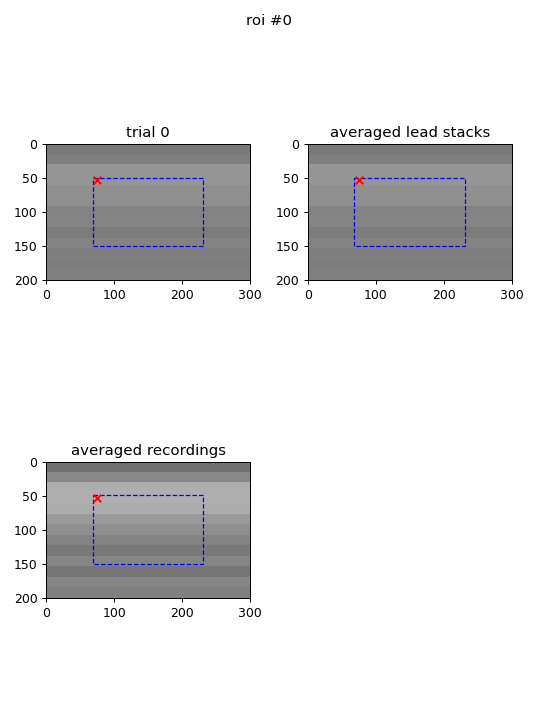

In [28]:
bsln_t0 = -0.3
bsln_t1 = -0.1
resp_t0 = -0.1
resp_t1 = 0.

bsln_mask = (lead_xaxis >= bsln_t0) * (lead_xaxis <= bsln_t1)
resp_mask = (lead_xaxis >= resp_t0) * (lead_xaxis <= resp_t1)
bsln = np.mean(lead_stacks[:, :, bsln_mask], axis=2)
resp = np.mean(lead_stacks[:, :, resp_mask], axis=2)

sub = resp - bsln
vmin = np.min(sub)
vmax = np.max(sub)

mean_lead_bsln = np.mean(mean_lead_stacks[:, bsln_mask], axis=1)
mean_lead_resp = np.mean(mean_lead_stacks[:, resp_mask], axis=1)
mean_lead_sub = mean_lead_resp - mean_lead_bsln

avg_lead_bsln = np.mean(avg_lead_stacks[:, bsln_mask], axis=1)
avg_lead_resp = np.mean(avg_lead_stacks[:, resp_mask], axis=1)
avg_lead_sub = avg_lead_resp - avg_lead_bsln

n_trials = sub.shape[1]
def title_fun(i):
    if i < n_trials:
        return "trial %i" % i
    elif i == n_trials:
        return "averaged lead stacks"
    elif i == n_trials + 1:
        return "averaged recordings"

sub_field_plotter = MultiStackPlotter(
    np.concatenate(
        [sub, np.expand_dims(mean_lead_sub, 1), np.expand_dims(avg_lead_sub, 1)],
        axis=1,
    ).transpose(1, 0, 2, 3),
    vmin=-.5,
    vmax=.5,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)

sub_field_updaters = []
for row in sub_field_plotter.ax:
    for ax in row:
        ax.add_patch(scan_field_rect())
        m = ax.scatter([0], [0], marker="x", c="red")
        sub_field_updaters.append(update_roi_mark(m))
        sub_field_updaters[-1](0)    
        
def sub_field_updater(_event):
    for u in sub_field_updaters:
        u(sub_field_plotter.idx)
        
sub_field_plotter.fig.canvas.mpl_connect("scroll_event", sub_field_updater)

sub_field_plotter.fig.tight_layout()

### Receptive field by variance during response window

<IPython.core.display.Javascript object>


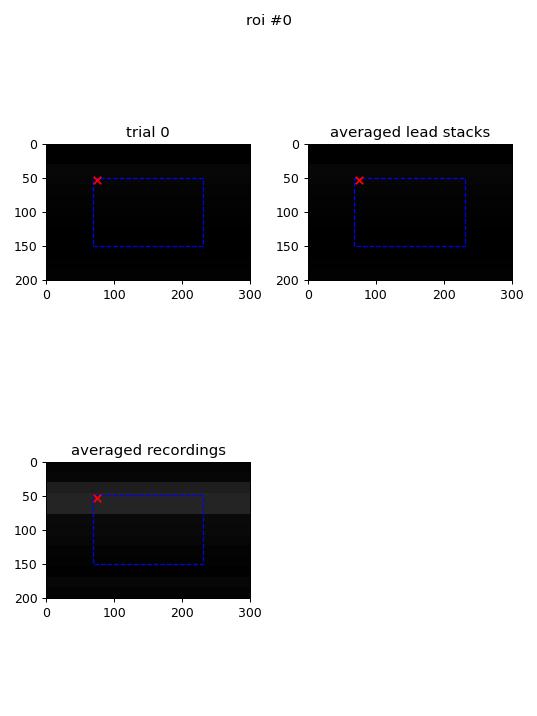

In [29]:
resp_t0 = -0.5
resp_t1 = 0.
resp_mask = (lead_xaxis >= resp_t0) * (lead_xaxis <= resp_t1)

lead_var = np.var(lead_stacks[:, :, resp_mask], axis=2)
mean_lead_var = np.var(mean_lead_stacks[:, resp_mask], axis=1, keepdims=True)
avg_lead_var = np.var(avg_lead_stacks[:, resp_mask], axis=1, keepdims=True)

vmin = np.min(mean_lead_var)
vmax = np.max(mean_lead_var)

var_field_plotter = MultiStackPlotter(
    np.concatenate(
        [lead_var, mean_lead_var, avg_lead_var],
#         [lead_var, mean_lead_var],
        axis=1,
    ).transpose(1, 0, 2, 3),
#     vmin=-.5,
#     vmax=.5,
    vmin=vmin,
    vmax=vmax,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)

var_field_updaters = []
for row in var_field_plotter.ax:
    for ax in row:
        ax.add_patch(scan_field_rect())
        m = ax.scatter([0], [0], marker="x", c="red")
        var_field_updaters.append(update_roi_mark(m))
        var_field_updaters[-1](0)    
        
def var_field_updater(_event):
    for u in var_field_updaters:
        u(var_field_plotter.idx)
        
var_field_plotter.fig.canvas.mpl_connect("scroll_event", var_field_updater)
var_field_plotter.fig.tight_layout()

### Receptive Field by difference in variance during response window and after the event

<IPython.core.display.Javascript object>


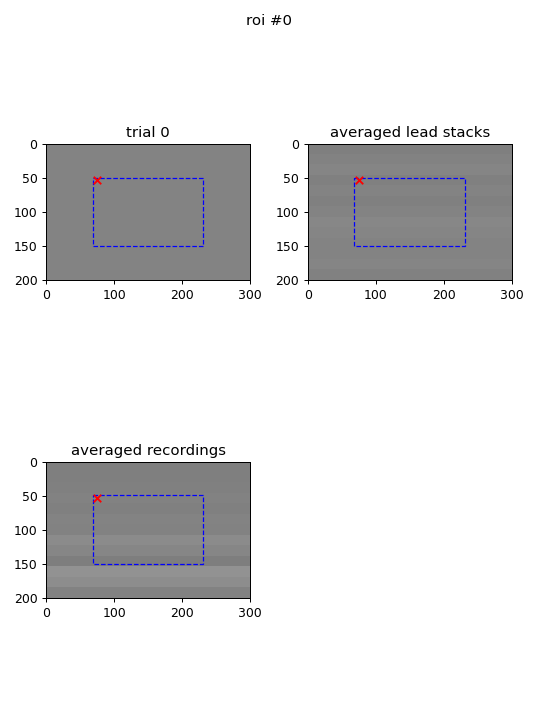

In [30]:
pre_t0 = -0.5
pre_t1 = 0.
post_t0 = 0.5
post_t1 = 1.

pre_mask = (lead_xaxis >= pre_t0) * (lead_xaxis <= pre_t1)
post_mask = (lead_xaxis >= post_t0) * (lead_xaxis <= post_t1)

before_var = np.var(lead_stacks[:, :, pre_mask], axis=2)
after_var = np.var(lead_stacks[:, :, post_mask], axis=2)
var_diff = before_var - after_var

mean_before_var = np.mean(mean_lead_stacks[:, pre_mask], axis=1, keepdims=True)
mean_after_var = np.mean(mean_lead_stacks[:, post_mask], axis=1, keepdims=True)
mean_var_diff = mean_before_var - mean_after_var

avg_before_var = np.mean(avg_lead_stacks[:, pre_mask], axis=1, keepdims=True)
avg_after_var = np.mean(avg_lead_stacks[:, post_mask], axis=1, keepdims=True)
avg_var_diff = avg_before_var - avg_after_var

vmin = np.min(avg_var_diff)
vmax = np.max(avg_var_diff)

var_diff_plotter = MultiStackPlotter(
    np.concatenate(
        [var_diff, mean_var_diff, avg_var_diff],
        axis=1,
    ).transpose(1, 0, 2, 3),
#     vmin=-.5,
#     vmax=.5,
    vmin=vmin,
    vmax=vmax,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)

var_diff_updaters = []
for row in var_diff_plotter.ax:
    for ax in row:
        ax.add_patch(scan_field_rect())
        m = ax.scatter([0], [0], marker="x", c="red")
        var_diff_updaters.append(update_roi_mark(m))
        var_diff_updaters[-1](0)    
        
def var_diff_updater(_event):
    for u in var_diff_updaters:
        u(var_diff_plotter.idx)
        
var_diff_plotter.fig.canvas.mpl_connect("scroll_event", var_diff_updater)
var_diff_plotter.fig.tight_layout()

In [31]:
print("Triggered Stimulus Contrast Variance (whole stimulus, all ROIs):")
print("  pre variance (%.3fs -> %.3fs) = %.5f" % (pre_t0, pre_t1, mean_before_var.mean()))
print("  post variance (%.3fs -> %.3fs) = %.5f" % (post_t0, post_t1, mean_after_var.mean()))
print("  post - pre = %.5f" % mean_var_diff.mean())

Triggered Stimulus Contrast Variance (whole stimulus, all ROIs):
  pre variance (-0.500s -> 0.000s) = 0.48615
  post variance (0.500s -> 1.000s) = 0.48817
  post - pre = -0.00203


### Receptive Field by difference in value range in windows before and after peak

Similar idea as the variance subtraction, but using `max(w) - min(w)` where `w` is the window of time defined by the `t` variables pre and post peak. The value for a particular ROI will therefore be positive if there is a larger range of values in the response zone than following the peak.  

<IPython.core.display.Javascript object>


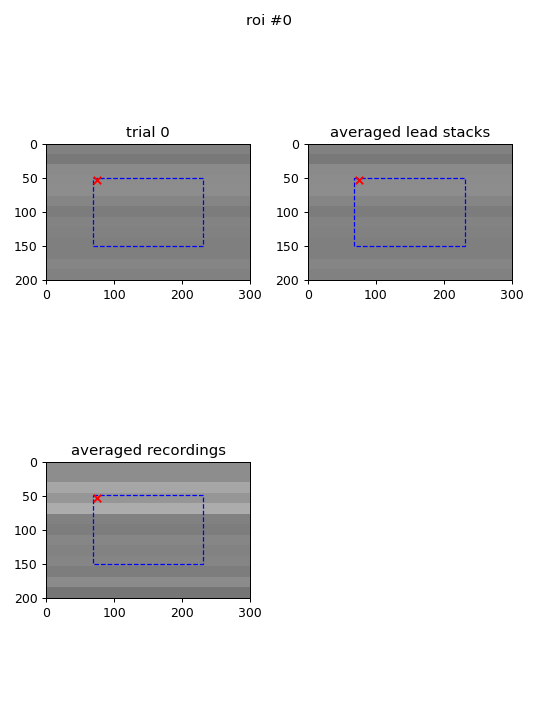

In [32]:
pre_t0 = -0.5
pre_t1 = 0
post_t0 = 0.5
post_t1 = 1.

pre_mask = (lead_xaxis >= pre_t0) * (lead_xaxis <= pre_t1)
post_mask = (lead_xaxis >= post_t0) * (lead_xaxis <= post_t1)

pre = lead_stacks[:, :, pre_mask]
pre_range = np.max(pre, axis=2) - np.min(pre, axis=2)
post = lead_stacks[:, :, post_mask]
post_range = np.max(post, axis=2) - np.min(post, axis=2)

range_sub = pre_range - post_range
vmin = np.min(range_sub)
vmax = np.max(range_sub)

mean_pre = mean_lead_stacks[:, pre_mask]
mean_pre_range = np.max(mean_pre, axis=1) - np.min(mean_pre, axis=1)
mean_post = mean_lead_stacks[:, post_mask]
mean_post_range = np.max(mean_post, axis=1) - np.min(mean_post, axis=1)
mean_range_sub = mean_pre_range - mean_post_range

avg_pre = avg_lead_stacks[:, pre_mask]
avg_pre_range = np.max(avg_pre, axis=1) - np.min(avg_pre, axis=1)
avg_post = avg_lead_stacks[:, post_mask]
avg_post_range = np.max(avg_post, axis=1) - np.min(avg_post, axis=1)
avg_range_sub = avg_pre_range - avg_post_range

range_sub_plotter = MultiStackPlotter(
    np.concatenate(
        [range_sub, np.expand_dims(mean_range_sub, 1), np.expand_dims(avg_range_sub, 1)],
        axis=1,
    ).transpose(1, 0, 2, 3),
    vmin=-.5,
    vmax=.5,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)

range_sub_updaters = []
for row in range_sub_plotter.ax:
    for ax in row:
        ax.add_patch(scan_field_rect())
        m = ax.scatter([0], [0], marker="x", c="red")
        range_sub_updaters.append(update_roi_mark(m))
        range_sub_updaters[-1](0)    
        
def range_sub_updater(_event):
    for u in range_sub_updaters:
        u(range_sub_plotter.idx)
        
range_sub_plotter.fig.canvas.mpl_connect("scroll_event", range_sub_updater)
range_sub_plotter.fig.tight_layout()

### Checking whether there is any pattern associated with gross centre and surround regions of the noise stimulation
Since the scan region is much smaller than the stimulus, we might expect the area in the centre directly above or neighbouring the recorded terminals may have a bias to positive centre signals. Depending on the size of the receptive fields and their offset from the terminals however, this might not necessarily be the case.

Set the centre field rectangle by spatial indices corresponding to the `raw_noise` stack, with `centre_{t,b,l,r}` ( top / bottom / left / right ) variables.

centre mask:
 [[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]]
surround mask:
 [[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]


<IPython.core.display.Javascript object>


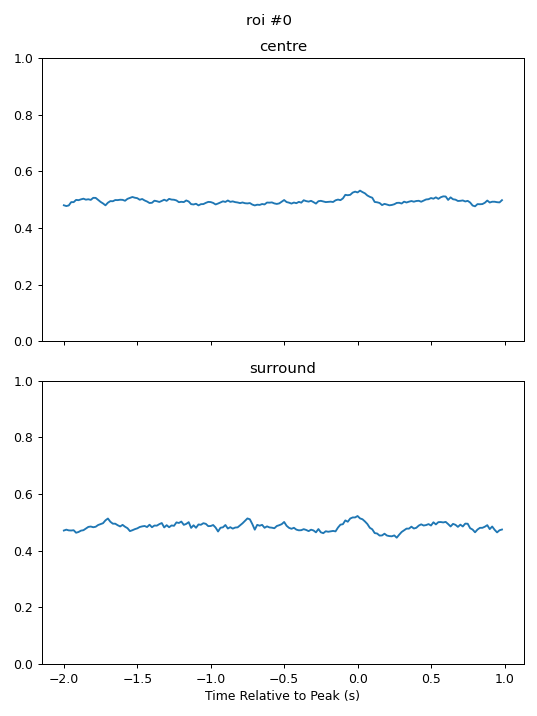

In [33]:
# centre_t = 6
# centre_b = 10
# centre_l = 3
# centre_r = 13
centre_t = 4
centre_b = 10
centre_l = 0
centre_r = 1
border = 1  # surround thickness (vertical padding around centre unless 1D vertical noise)

centre_mask = np.zeros((noise_cols, noise_rows), dtype=int)
centre_mask[centre_t:centre_b, centre_l:centre_r] = 1

surround_mask = np.zeros((noise_cols, noise_rows), dtype=int)
if raw_noise.shape[1] == 1:
    surround_mask[centre_t:centre_b, centre_l-border:centre_r+border] = 1
else:
    surround_mask[centre_t-border:centre_b+border, centre_l:centre_r] = 1
surround_mask -= centre_mask

print("centre mask:\n", centre_mask)
print("surround mask:\n", surround_mask)

lead_stacks_flat = lead_stacks.reshape(n_kept_rois, n_trials, lead_frames, -1)
centre_beams = np.mean(
    lead_stacks_flat[:, :, :, centre_mask.reshape(-1).astype(bool)], axis=3)
surround_beams = np.mean(
    lead_stacks_flat[:, :, :, surround_mask.reshape(-1).astype(bool)], axis=3)

centre_surround_plotter = MultiWavePlotter(
#     [centre_beams, surround_beams],
    [np.mean(centre_beams, axis=1, keepdims=True), np.mean(surround_beams, axis=1, keepdims=True)],
    xaxis=lead_xaxis,
    ymin=0,
    ymax=1,
    title_fmt_fun=lambda i: "centre" if not i else "surround",
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    figsize=(6, 8),
    sharex=True,
)
centre_surround_plotter.ax[1].set_xlabel("Time Relative to Peak (s)")
centre_surround_plotter.fig.tight_layout()

### Average of all centre-surrounds

<IPython.core.display.Javascript object>


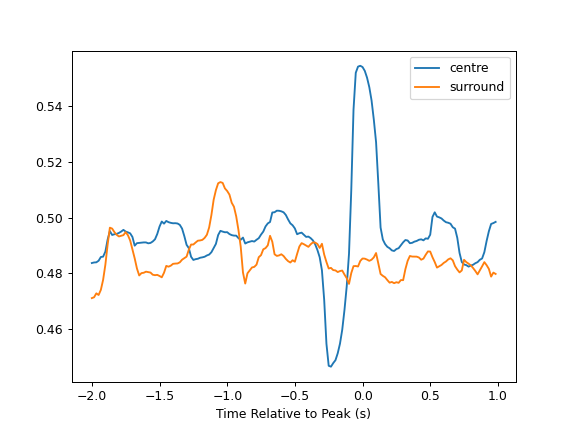

(224, 1, 180, 13, 1)


In [34]:
avg_centre_beam = np.mean(centre_beams, axis=(0, 1))
avg_surround_beam = np.mean(surround_beams, axis=(0, 1))
avg_all_beam = np.mean([avg_centre_beam, avg_surround_beam], axis=0)
avg_centre_surround_fig, avg_centre_surround_ax = plt.subplots(1)
avg_centre_surround_ax.plot(lead_xaxis, avg_centre_beam, label="centre")
avg_centre_surround_ax.plot(lead_xaxis, avg_surround_beam, label="surround")
# avg_centre_surround_ax.plot(lead_xaxis, avg_all_beam, label="all")
avg_centre_surround_ax.set_xlabel("Time Relative to Peak (s)")
avg_centre_surround_ax.legend()
print(lead_stacks.shape)

### Average of all ROI Triggered Movies
This is done to see whether any clear pattern emerges with respect to receptive fields. Since the noise stimulus is quite large relative to the imaged bipolar terminals, we might expect to see a bias of surround-like kernels out from the middle. Or perhaps an average centre like kernel in the middle, if we expect the receptive fields of the bipolar cells to overlap somewhat.

<IPython.core.display.Javascript object>


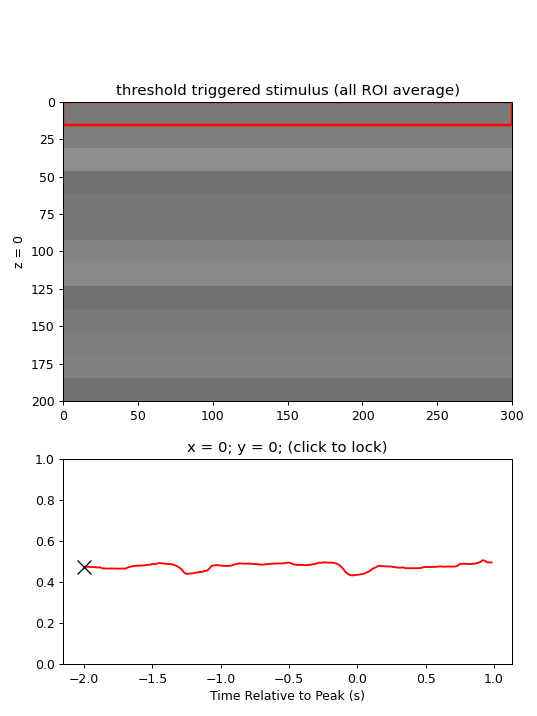

In [35]:
roi_avg_lead_stack_plot = StackExplorer(
    all_roi_lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8),
    dims=(stim_width, stim_height),
)
roi_avg_lead_stack_plot.stack_ax.set_title("threshold triggered stimulus (all ROI average)")
roi_avg_lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
roi_avg_lead_stack_plot.fig.tight_layout()

In [36]:
do_cross_corr = True
if do_cross_corr:
    lead_pts = int(lead_time * hz)
    post_pts = int(post_time * hz)
    
    # add avg_recs to end, then split out the results to decrease duplication
    combined_recs = np.concatenate(
        [grid_recs, np.expand_dims(avg_grid_recs, 0)], axis=0)
    
    combined_recs = combined_recs[:, :, stim_start_idx-lead_pts:stim_end_idx+post_pts]
    new_len = int(noise_hz / hz * combined_recs.shape[-1])
    combined_recs = map_axis(lambda a: signal.resample(a, new_len), combined_recs)
    n = combined_recs.shape[-1]
    
    mode = "valid"
    if mode == "valid":
        corr_len = max(n, noise_frames) - min(n, noise_frames) + 1
    elif mode == "same":
        corr_len = max(n, noise_frames)
    else:
        corr_len = n + noise_frames - 1  # full
    
    cross_stacks = []
    for i in range(combined_recs.shape[1]): 
        roi = []
        for j in range(combined_recs.shape[0]):
            trial = []
            for c in range(raw_noise.shape[1]):
                for r in range(raw_noise.shape[2]):
                    nz = raw_noise[:, c, r] - 0.5
                    resp = combined_recs[j, i]
                    trial.append(np.flip(np.correlate(resp, nz, mode=mode)))
            roi.append(
                np.stack(trial, axis=1).reshape(
                    corr_len, raw_noise.shape[1], raw_noise.shape[2])) 
        cross_stacks.append(roi)    
    
    del combined_recs
            
    # split trial and average output
    avg_cross_stacks = np.stack([l[-1] for l in cross_stacks], axis=0)
    cross_stacks = np.stack([l[:-1] for l in cross_stacks], axis=0)
    
    print("avg_cross_stacks shape:", avg_cross_stacks.shape)

avg_cross_stacks shape: (224, 179, 13, 1)


<IPython.core.display.Javascript object>


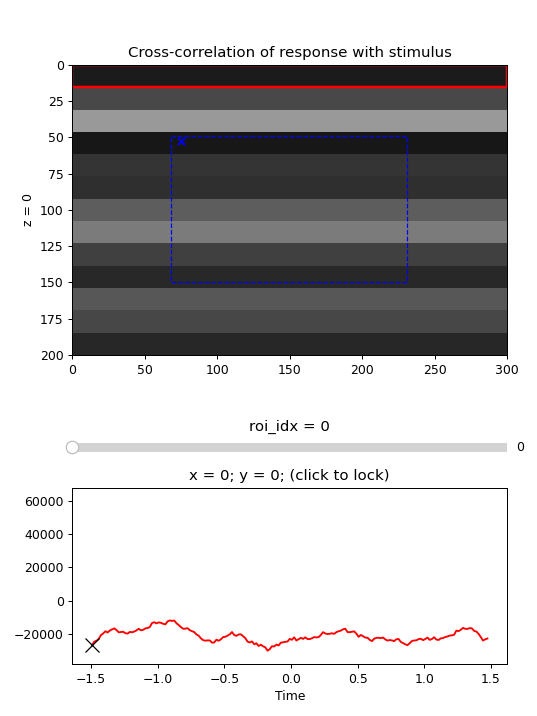

In [37]:
if do_cross_corr:
    cross_xaxis = (np.arange(corr_len) - (corr_len / 2 )) * (1 / noise_hz)
    cross_stack_plot = StackExplorer(
        cross_stacks,
    #     np.expand_dims(avg_cross_stacks, 1),
        zaxis=cross_xaxis,
        delta=1,
        roi_sz=1,
        n_fmt_fun=lambda i: "roi_idx = %i" % i,
        dims=(stim_width, stim_height),
        figsize=(6, 8)
    )
    cross_stack_plot.stack_ax.set_title("Cross-correlation of response with stimulus")
    cross_stack_plot.beam_ax.set_xlabel("Time")
    cross_stack_plot.fig.tight_layout()
    
    cross_stack_plot.ax[0].add_patch(scan_field_rect())
    cross_roi_mark = cross_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
    update_roi_mark(cross_roi_mark)(0)    
    if cross_stack_plot.n_sz > 1:
        cross_stack_plot.n_slider.on_changed(update_roi_mark(cross_roi_mark))
    cross_stack_plot.fig.show()

<IPython.core.display.Javascript object>


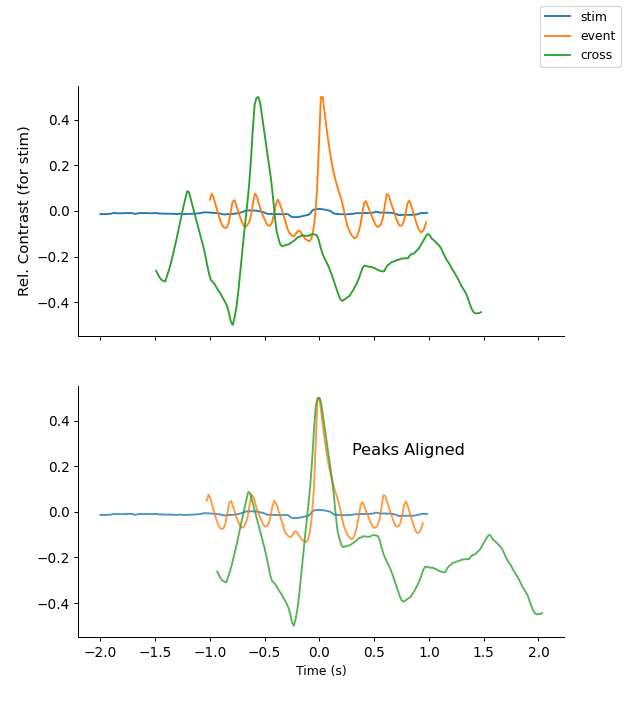

In [38]:
avg_trig_event = np.mean(triggered_events, axis=(0, 1, 3, 4))
avg_trig_lead = np.mean(lead_stacks, axis=(0, 1, 3, 4))
avg_cross_corr = np.mean(cross_stacks, axis=(0, 1, 3, 4))

scaled_trig_event = avg_trig_event / np.max(avg_trig_event) / 2.
scaled_trig_lead = avg_trig_lead - 0.5
scaled_cross_corr = avg_cross_corr - np.min(avg_cross_corr)
scaled_cross_corr = scaled_cross_corr / np.max(scaled_cross_corr) - 0.5
# scaled_trig_event = avg_trig_event / np.max(avg_trig_event)
# scaled_trig_lead = (avg_trig_lead - 0.5) * 2.

offset_event_xaxis = event_xaxis - event_xaxis[np.argmax(scaled_trig_event)]
offset_lead_xaxis = lead_xaxis - lead_xaxis[np.argmax(scaled_trig_lead)]
offset_cross_xaxis = cross_xaxis - cross_xaxis[np.argmax(scaled_cross_corr)]

lead_vs_event_fig, lead_vs_event_ax = plt.subplots(
    2, sharex=True, sharey=True, figsize=(7, 8))

lead_vs_event_ax[0].plot(lead_xaxis, scaled_trig_lead, label="stim")
lead_vs_event_ax[1].plot(offset_lead_xaxis, scaled_trig_lead, alpha=0.8)

lead_vs_event_ax[0].plot(event_xaxis, scaled_trig_event, label="event")
lead_vs_event_ax[1].plot(offset_event_xaxis, scaled_trig_event, alpha=0.8)

lead_vs_event_ax[0].plot(cross_xaxis, scaled_cross_corr, label="cross")
lead_vs_event_ax[1].plot(offset_cross_xaxis, scaled_cross_corr, alpha=0.8)

lead_vs_event_ax[1].text(0.3, 0.25, "Peaks Aligned", fontsize=13)
lead_vs_event_ax[0].set_ylabel("Rel. Contrast (for stim)", fontsize=12)
lead_vs_event_ax[-1].set_xlabel("Time (s)")
lead_vs_event_fig.legend()

clean_axes(lead_vs_event_ax)

In [39]:
output_analysis = False
if output_analysis:
    pack_hdf(
        "triggered_stimuli", 
        {
            "raw_noise": raw_noise,
            "noise_hz": noise_hz,
            "noise_freq": noise_freq,
            "noise_xaxis": noise_xaxis,
            "noise_frame_times": noise_frame_times,
            "recs": stacks,
            "recs_xaxis": recs_xaxis,
            "recs_hz": hz,
            "recs_dt": dt,
            "rec_pts_per_cycle": rec_pts_per_cycle,
            "grid_w": grid_w,
            "grid_h": grid_h,
            "grid_rows": grid_rows,
            "grid_cols": grid_cols,
            "grid_recs": grid_recs,
            "grid_detrend_conv": detrend_conv,
            "n_peaks_used": n_legals,
            "lead": lead_stacks,
            "lead_conv": lead_stacks_conv,
            "mean_lead": mean_lead_stacks,
            "avg_lead": avg_lead_stacks,
            "lead_xaxis": lead_xaxis,
            "pos_to_roi": pos_to_roi,
            "roi_locs": grid_locs[(pos_to_roi)],
            "rec_width": rec_width,
            "rec_height": rec_height,
            "rec_x_offset": rec_x_offset,
            "rec_y_offset": rec_y_offset,
            "col_x": col_x,
            "row_y": row_y,
            "x_corner": x_corner,
            "y_corner": y_corner,
            "stim_height": stim_height,
            "stim_width": stim_width,
            "event_xaxis": event_xaxis,
            "triggered_events": triggered_events,
            "trial_peak_times": trial_peak_times,
            "trial_peak_lags": trial_peak_lags,
            "cross_xaxis": cross_xaxis,
            "cross_stacks": cross_stacks,
        }
    )

In [40]:
# relevant appropriate only when using full field ROI
output_triggered_waves = False
if output_triggered_waves and raw_noise.shape[1] == 1 and raw_noise.shape[2] == 1:
    pack_hdf(
        "triggered_waves_%s" % depth, 
        {
            "rec": np.squeeze(raw_grid_recs),
            "rec_xaxis": recs_xaxis,
            "glusnfr_template": template,
            "noise_wave": np.squeeze(raw_noise),
            "noise_xaxis": noise_xaxis,
            "avg_trig_event": avg_trig_event,
            "event_xaxis": event_xaxis,
            "avg_trig_lead": avg_trig_lead,
            "lead_xaxis": lead_xaxis,
            "scaled_trig_event": scaled_trig_event,
            "offset_event_xaxis": offset_event_xaxis,
            "scaled_trig_lead": scaled_trig_lead,
            "offset_lead_xaxis": offset_lead_xaxis,
            "avg_cross_corr": avg_cross_corr,
            "cross_xaxis": cross_xaxis,
            "scaled_cross_corr": scaled_cross_corr,
            "offset_cross_xaxis": offset_cross_xaxis,
        }
    )